<h1> Exploratory Data Analysis (EDA) </h1>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Add the libraries

In [ ]:
!pip install emoji
# !pip install plotly==5.13.1 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=01dcd7be4acde85d5d4455b3863ea254070dac4927db759391043c99caeacf44
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load the combined data set

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/datasets/downloaded-data/combined_df.csv")
df.head()

,Unnamed: 0,session_id,query,intent,page_funnel,responses,fallback,fallback_funnel,feedback,first_intent,fulfillment_error,source,origin,preferences_shown,preference_picked,products_shown,product_clicked,timestamp,session_duration,isTestMessage
0,0,b4f10369-b2f4-4563-8133-0cc7bcaeb2e4,ons abobbement lijkt afgesloten terwijl we wel...,faq.thanks,['Else' 'Else'],['Graag gedaan!'],False,NaN,NaN,False,[],ACTIONS_ON_GOOGLE,NaN,NaN,NaN,[],NaN,2022-02-21 07:23:32.446993+00:00,NaN,False
1,1,99c92c26-cdfc-425e-b0a9-649f93c9cc2b,Ik ga wel bellen,faq.thanks,['Else' 'Else'],['Graag gedaan!'],False,NaN,NaN,False,[],ACTIONS_ON_GOOGLE,NaN,NaN,NaN,[],NaN,2022-03-03 08:00:51.074421+00:00,140.0,False
2,2,99c92c26-cdfc-425e-b0a9-649f93c9cc2b,Ik ga wel bellen,faq.thanks,['Else' 'Else'],['Graag gedaan!'],False,NaN,NaN,False,[],ACTIONS_ON_GOOGLE,NaN,NaN,NaN,[],NaN,2022-03-03 08:00:51.074421+00:00,140.0,False
3,3,965900e2-f1a3-4106-94a3-b76ef5ad86b1,Dank je,faq.thanks,['Else' 'Else'],['Graag gedaan!'],False,NaN,NaN,False,[],ACTIONS_ON_GOOGLE,NaN,NaN,NaN,[],NaN,2021-12-16 07:59:45.233663+00:00,105.0,False
4,4,33bbbc4d-f1eb-40b4-be85-08de9ed4193b,Is mijn bestelling bekend bij jullie? Betaling...,faq.thanks,['Welcome' 'Welcome'],['Graag gedaan!'],False,NaN,NaN,True,[],ACTIONS_ON_GOOGLE,NaN,NaN,NaN,[],NaN,2021-12-20 11:58:49.831912+00:00,NaN,False


In [ ]:
# drop the Unnamed column
df.drop(df.columns[df.columns.str.contains('Unnamed',case = False)],axis = 1, inplace = True)

### Explore the data set

In [ ]:
df.shape

(75814, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75814 entries, 0 to 75813
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   session_id         75512 non-null  object 
 1   query              75814 non-null  object 
 2   intent             75814 non-null  object 
 3   page_funnel        75814 non-null  object 
 4   responses          75512 non-null  object 
 5   fallback           75512 non-null  object 
 6   fallback_funnel    5360 non-null   object 
 7   feedback           684 non-null    float64
 8   first_intent       75512 non-null  object 
 9   fulfillment_error  75512 non-null  object 
 10  source             75512 non-null  object 
 11  origin             0 non-null      float64
 12  preferences_shown  32627 non-null  object 
 13  preference_picked  37841 non-null  object 
 14  products_shown     75512 non-null  object 
 15  product_clicked    5510 non-null   object 
 16  timestamp          755

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
feedback,684.0,3.739766,1.172949,1.0,3.0,4.0,5.0,7.0
origin,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
session_duration,19035.0,84.321618,312.275469,0.0,0.0,33.0,89.0,23589.0


In [ ]:
df.isnull().sum()

session_id             302
query                    0
intent                   0
page_funnel              0
responses              302
fallback               302
fallback_funnel      70454
feedback             75130
first_intent           302
fulfillment_error      302
source                 302
origin               75814
preferences_shown    43187
preference_picked    37973
products_shown         302
product_clicked      70304
timestamp              302
session_duration     56779
isTestMessage          302
dtype: int64

In [ ]:
pd.set_option("display.max_rows", None)
df["intent"].value_counts()

event.highpressure.start                    8019
answer.yes                                  6752
answer.no                                   5814
event.floorcleaner.start                    5575
ev_welcome_tijdschrift                      5417
Fallback (unable to determine which one)    5360
intent.submit                               4432
purpose.answer.toepassing                   4275
event.satisfactionFlow                      2847
event.productClicked                        2289
intent.yes                                  2005
purpose.answer.else                         1857
event.floorcleaner.satisfactionFlow         1669
intent.activerenopzeggen                    1484
intent.else                                 1471
event.floorcleaner.productClicked           1292
intent.no                                   1284
surface.answer.20-50                        1092
faq.abonnementOpzeggen                       953
intent.inloggen                              877
colour.answer.noPref

> <h5>There are two row instances of "Fallback" and "Fallback (unable to determine which one)", which have the same meaning. Thus, categorizing them together is a logical solution.</h5>

In [ ]:
# Replace "Fallback" with "Fallback (unable to determine which one)" 
df.loc[df["intent"] == "Fallback", "intent"] = "Fallback (unable to determine which one)"

In [ ]:
# Replace "Fallback" with "Fallback (unable to determine which one)" 
df.loc[df["intent"] == "any.fallback", "intent"] = "Fallback (unable to determine which one)"

In [ ]:
# The "Default Welcome Intent" is not useful, therefore excluding it.
df = df[df["intent"] != "Default Welcome Intent"]

In [ ]:
# check for duplicates in the 'query' column
duplicates = df.duplicated(subset=["query" ,"timestamp"])
print("Number of duplicate timestamps:", duplicates.sum())

Number of duplicate timestamps: 422


In [ ]:
# drop duplicates based on the 'query' and 'timestamp' columns
df.drop_duplicates(subset=["query", "timestamp"], inplace=True)

# print the number of remaining rows in the DataFrame
print("Number of remaining rows:", len(df))

Number of remaining rows: 75374


In [ ]:
# check which rows are starting with the below string
dupl = df[df["query"].str.startswith("Wanneer is de app weer bruikbaar")]

# select only the 'query' column to see the user's input
dupli = dupl[["query", "timestamp"]]

# display the resulting DataFrame
dupli.head(50)

,query,timestamp
70262,Wanneer is de app weer bruikbaar. Ik ksn geen ...,2021-12-24 12:59:06.140691+00:00
72932,Wanneer is de app weer bruikbaar. Ik ksn geen ...,2021-12-24 12:59:18.990265+00:00
73247,Wanneer is de app weer bruikbaar. Ik ksn geen ...,2021-12-24 13:06:07.336400+00:00
73322,Wanneer is de app weer bruikbaar. Ik ksn geen ...,2021-12-24 13:06:41.694562+00:00


In [ ]:
# group the DataFrame by the 'query' and 'timestamp' columns
groups = df.groupby(["query", "timestamp"])

# count the number of rows in each group
counts = groups.size()

# filter the groups to only show those with more than one row
duplicates = groups.filter(lambda x: len(x) > 1)

# print the duplicates
print(duplicates)

Empty DataFrame
Columns: [session_id, query, intent, page_funnel, responses, fallback, fallback_funnel, feedback, first_intent, fulfillment_error, source, origin, preferences_shown, preference_picked, products_shown, product_clicked, timestamp, session_duration, isTestMessage]
Index: []


After using the "drop_duplicates", there are still some remaining rows, which are not removed. 

> The following code converts all the values in the timestamp column to a consistent datetime format, drops any duplicate rows based on the query and timestamp columns, and prints the number of remaining rows in the DataFrame.

In [ ]:
# convert the 'timestamp' column to a consistent format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# drop duplicates based on the 'query' and 'timestamp' columns
df.drop_duplicates(subset=["query", "timestamp"], inplace=True)

# print the number of remaining rows in the DataFrame
print("Number of remaining rows:", len(df))

Number of remaining rows: 75374


Apparently, the above code did not find any duplicates. 
> Therefore, I will try another approach.

In [ ]:
# find the duplicates based on the 'query' and 'timestamp' columns
duplicates = df[df.duplicated(subset=["query", "timestamp"], keep=False)]

# print out the number of rows in the duplicates DataFrame
print("Number of duplicate rows:", len(duplicates))

# loop over the duplicates and print their unique values for each column
for _, row in duplicates.iterrows():
    print("Query:", row["query"])
    print("Timestamp:", row["timestamp"])
    print("Session ID:", row["session_id"])
    print("Intent:", row["intent"])

Number of duplicate rows: 0


In [ ]:
print(df["query"].shape, df["timestamp"].shape)

(75374,) (75374,)


In [ ]:
pd.set_option("display.max_rows", None)
df["intent"].value_counts()

event.highpressure.start                    8019
answer.yes                                  6752
answer.no                                   5814
Fallback (unable to determine which one)    5650
event.floorcleaner.start                    5575
ev_welcome_tijdschrift                      5353
intent.submit                               4432
purpose.answer.toepassing                   4275
event.satisfactionFlow                      2847
event.productClicked                        2289
intent.yes                                  1985
purpose.answer.else                         1857
event.floorcleaner.satisfactionFlow         1669
intent.activerenopzeggen                    1471
intent.else                                 1458
event.floorcleaner.productClicked           1292
intent.no                                   1268
surface.answer.20-50                        1092
faq.abonnementOpzeggen                       944
intent.inloggen                              872
colour.answer.noPref

In [ ]:
# create a boolean mask for rows that contain "event" or "ev_" 
event_mask = df["intent"].str.startswith("event") | df["intent"].str.startswith("ev_")

# create a new filtered DataFrame without the events
filt_df = df[~event_mask].reset_index(drop=True)

In [ ]:
filt_df.shape

(48019, 19)

In [ ]:
filt_df["intent"].value_counts()

answer.yes                                  6752
answer.no                                   5814
Fallback (unable to determine which one)    5650
intent.submit                               4432
purpose.answer.toepassing                   4275
intent.yes                                  1985
purpose.answer.else                         1857
intent.activerenopzeggen                    1471
intent.else                                 1458
intent.no                                   1268
surface.answer.20-50                        1092
faq.abonnementOpzeggen                       944
intent.inloggen                              872
colour.answer.noPreference                   803
colour.answer.white                          789
satisfaction.received                        710
surface.answer.50-80                         698
faq.cannotLogin                              661
surface.answer.100                           567
faq.problemenActiveren                       541
surface.answer.80-10

In [ ]:
filt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48019 entries, 0 to 48018
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   session_id         47921 non-null  object             
 1   query              48019 non-null  object             
 2   intent             48019 non-null  object             
 3   page_funnel        48019 non-null  object             
 4   responses          47921 non-null  object             
 5   fallback           47921 non-null  object             
 6   fallback_funnel    5335 non-null   object             
 7   feedback           684 non-null    float64            
 8   first_intent       47921 non-null  object             
 9   fulfillment_error  47921 non-null  object             
 10  source             47921 non-null  object             
 11  origin             0 non-null      float64            
 12  preferences_shown  23085 non-null  object     

<AxesSubplot:>

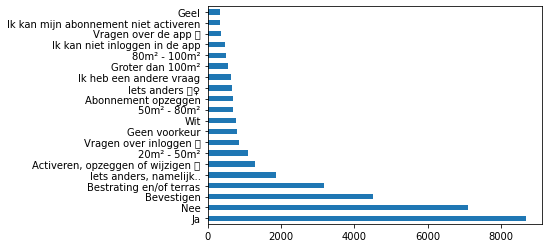

In [ ]:
# look which are the 20 most common values in the query column
filt_df["query"].value_counts()[:20].plot(kind='barh')

In [ ]:
filt_df["text_length"] = filt_df["query"].astype(str).apply(len)
filt_df["text_word_count"] = filt_df["query"].apply(lambda x: len(str(x).split()))

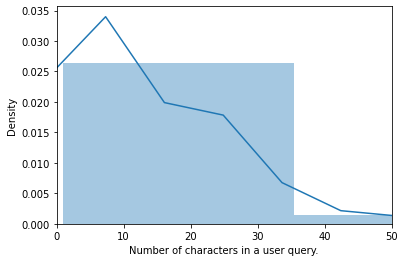

In [ ]:
# plot the length of the characters in a user query
sns.distplot(filt_df["text_length"])
plt.xlim([0, 50]);
plt.xlabel("Number of characters in a user query.");

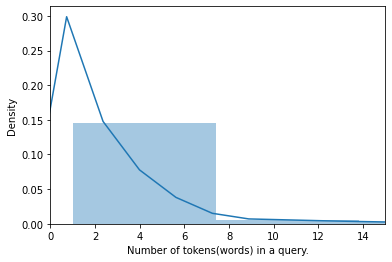

In [ ]:
# plot the number of words in a user query
sns.distplot(filt_df["text_word_count"])
plt.xlim([0, 15]);
plt.xlabel("Number of tokens(words) in a query.");

In [ ]:
filt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48019 entries, 0 to 48018
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   session_id         47921 non-null  object             
 1   query              48019 non-null  object             
 2   intent             48019 non-null  object             
 3   page_funnel        48019 non-null  object             
 4   responses          47921 non-null  object             
 5   fallback           47921 non-null  object             
 6   fallback_funnel    5335 non-null   object             
 7   feedback           684 non-null    float64            
 8   first_intent       47921 non-null  object             
 9   fulfillment_error  47921 non-null  object             
 10  source             47921 non-null  object             
 11  origin             0 non-null      float64            
 12  preferences_shown  23085 non-null  object     

## Look into some of the query data grouped by intent.

In [ ]:
# check what's the data for the queries, which are with intent satisfactionFeedback.answer

# filter the rows where the intent starts with "satisfactionFeedback.answer"
sat_df = filt_df[filt_df["intent"].str.contains("satisfactionFeedback.answer")]

# select only the 'query' column to see the user's input
sat_df = sat_df[["query"]]

# display the resulting DataFrame
sat_df.head(20)

,query
2347,nee
2350,zeker
2352,"cvnmnb,.nbvc"
2357,er ging iets mis in het begin bij de oppervlak...
2358,hoe werkt reinigingsmiddel
2368,Dit advies is top
2375,nee
2383,het was prima hoor
2392,prima advies
2408,nee


In [ ]:
# check what's the data for the queries, which are with intent intent.notsucceeded 

# filter the rows where the intent starts with "faq.geenPrijs"
int_df = df[df["intent"].str.contains("intent.notsucceeded")]

# select only the 'query' column to see the user's input
int_df = int_df[["query"]]

# display the resulting DataFrame
int_df.head(20)

,query
734,niet gelukt
738,Niet gelukt
739,diyt lukt niet
740,Niet gelukt
741,Dat probeer ik steeds maar pagina refresh niet
742,dat lukt me dus niet
744,dat lukt niet online
745,Het lukt niet
746,dat werkt niet
747,Niet gelukt


In [ ]:
# check what's the data for the queries, which are with intent intent.notsucceeded 

# filter the rows where the intent starts with "faq.geenPrijs"
int_df = filt_df[filt_df["intent"].str.contains("intent.notsucceeded")]

# select only the 'query' column to see the user's input
int_df = int_df[["query"]]

# display the resulting DataFrame
int_df.head(20)

,query
437,niet gelukt
441,Niet gelukt
442,diyt lukt niet
443,Niet gelukt
444,Dat probeer ik steeds maar pagina refresh niet
445,dat lukt me dus niet
447,dat lukt niet online
448,Het lukt niet
449,dat werkt niet
450,Niet gelukt


In [ ]:
# check what's the data for the queries, which are with intent faq.geenPrijs

# filter the rows where the intent starts with "faq.geenPrijs"
faq_df = filt_df[filt_df["intent"].str.contains("faq.geenPrijs")]

# select only the 'query' column to see the user's input
faq_df = faq_df[["query"]]

# display the resulting DataFrame
faq_df.head(20)

,query
2360,waarom heeft een produt geen prijs
2363,waarom staat er geen prijs
2369,Waarom heeft dit product geen prijs?
2377,waarom staat er geen prijs bij?
2378,waarom staat er geen prijs bij het product?
2379,waarom staat er geen prijs?
2381,prijs?
2405,waarom staat er geen prijs bij het product?
2410,hoi inge zie je dit vraagteken ?
2411,zie je dit?


In [ ]:
# check what's the data for the queries, which are with intent intent.notsucceeded 

# filter the rows where the intent starts with "faq.geenPrijs"
int_df = filt_df[filt_df["query"].str.contains("klantnummer")]

# select only the 'query' column to see the user's input
int_df = int_df[["query"]]

# display the resulting DataFrame
int_df.head(20)

,query
42942,De voornaam van klantnummer 0058203167 is Carl...
43229,Waar vind ik mijn klantnummer
44441,Ik wil mijn klantnummer weten
45242,Mijn klantnummer is 25.31.64.03 mevr. T.Haandr...
45323,Mijn klantnummer is 106022415 wanneer krijg ik...
45903,"Goedemorgen, mijn klantnummer is 0040778072 en..."


In [ ]:
# check what's the data for the queries, which are with intent faq.problemenActiveren

# filter the rows where the intent starts with "faq.problemenActiveren"
faq_pr_df = filt_df[filt_df["intent"].str.contains("faq.problemenActiveren")]

# select only the 'query' column to see the user's input
faq_pr_df = faq_pr_df[["query"]]

# display the resulting DataFrame
faq_pr_df.head(20)

,query
35496,Ik moet mijn account activeren maar ben het wa...
35497,Ik kan mijn digitaal abonnement niet activeren...
35498,"Hoi, ik heb net mijn code ingevoerd om 4 weken..."
35499,"Wachtwoord vergeten, maar mijn e-mail adres is..."
35500,Ik wil mijn abonnement niet activeren maar nie...
35501,Kan mijn account niet activeren
35502,Registratie lukt niet
35503,Geen bevestigingsmail ontvangen
35504,Ik wil mijn Hearst abonnement activeren maar i...
35505,account activeren voor abonnementsnummer 38036...


In [ ]:
# check what's the data for the queries, which are with intent surface.answer.20-50

# filter the rows where the intent starts with "faq.problemenActiveren"
surf_df = filt_df[filt_df["intent"].str.contains("surface.answer.20-50")]

# select only the 'query' column to see the user's input
surf_df = surf_df[["query"]]

# display the resulting DataFrame
surf_df.head()

,query
31554,20m² - 50m²
31555,20m² - 50m²
31556,20m² - 50m²
31557,20m² - 50m²
31558,20m² - 50m²


In [ ]:
# check what's the data for the queries, which are with intent intent.phoneOs

# filter the rows where the intent starts with "faq.problemenActiveren"
ph_df = filt_df[filt_df["intent"].str.contains("intent.phoneOs")]

# select only the 'query' column to see the user's input
ph_df = ph_df[["query"]]

# display the resulting DataFrame
ph_df.head()

,query
1240,Apple (iOS)
1241,Apple (iOS)
1242,Apple (iOS)
1243,Apple (iOS)
1244,Apple (iOS)


In [ ]:
# check what's the data for the queries, which are with intent faq.noNewEdition

# filter the rows where the intent starts with "faq.problemenActiveren"
faqn_df = filt_df[filt_df["intent"].str.contains("faq.noNewEdition")]

# select only the 'query' column to see the user's input
faqn_df = faqn_df[["query"]]

# display the resulting DataFrame
faqn_df.tail()

,query
343,De link werk niet
344,De link doetbhet niet
345,Ik heb mijn abonnement omgezet van Veronica Ma...
346,Heb ik al een paar keer gedaan maar komt niet ...
347,ik krijg normaal toch de magazine ook via de p...


In [ ]:
# check which rows are starting with the below string
dupli = df[df["query"].str.startswith("Etwas anderes,")]

# select only the 'query' column to see the user's input
dupli = dupli[["query", "timestamp"]]

# display the resulting DataFrame
dupli.head(20)

,query,timestamp
73734,"Etwas anderes, nämlich ...",2021-05-26 09:03:48.571788+00:00
73753,"Etwas anderes, nämlich ...",2021-05-27 06:14:40.325907+00:00
73754,"Etwas anderes, nämlich ...",2021-05-27 06:27:45.662556+00:00
73755,"Etwas anderes, nämlich ...",2021-05-27 06:28:49.475679+00:00
73756,"Etwas anderes, nämlich ...",2021-05-27 06:28:54.878064+00:00
73758,"Etwas anderes, nämlich ...",2021-05-27 07:57:57.808658+00:00
73759,"Etwas anderes, nämlich ...",2021-05-27 07:58:11.371828+00:00
73760,"Etwas anderes, nämlich ...",2021-05-27 08:01:45.362914+00:00


### Experimenting when dropping all the duplicates from the data. This will lead to having less data available.

In [ ]:
new_df = filt_df

In [ ]:
# sort the DataFrame by timestamp
new_df.sort_values(by="timestamp", ascending=False, inplace=True)

# drop duplicates based on the 'query' column, keeping the most recent occurrence
new_df.drop_duplicates(subset=["query"], keep="first", inplace=True)

In [ ]:
new_df_download = new_df.to_csv("cleaned_queries.csv")

In [ ]:
new_df["intent"].value_counts()

Fallback (unable to determine which one)    5003
purpose.answer.toepassing                    464
satisfactionFeedback.answer                  243
faq.abonnementOpzeggen                       216
faq.problemenActiveren                       183
faq.medewerkerSpreken                        167
faq.cannotLogin                              167
faq.noNewEdition                             156
faq.postcodeRecognize                        126
faq.appFail                                   95
faq.geenPrijs                                 62
faq.abonnementWijzigen                        61
faq.aanbod                                    56
faq.thanks                                    55
faq.webReaderFail                             50
usecase.answer.usecases                       37
faq.noDiscount                                30
intent.notsucceeded                           28
faq.abonnementEnded                           28
intent.activerenopzeggen                      26
faq.appVersion      

In [ ]:
new_df.shape

(7715, 21)

In [ ]:
new_df["text_length"] = new_df["query"].astype(str).apply(len)
new_df["text_word_count"] = new_df["query"].apply(lambda x: len(str(x).split()))

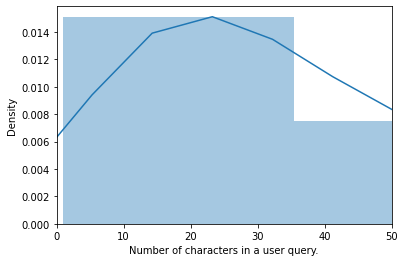

In [ ]:
# plot the length of the characters in a user query
sns.distplot(new_df['text_length'])
plt.xlim([0, 50]);
plt.xlabel('Number of characters in a user query.');

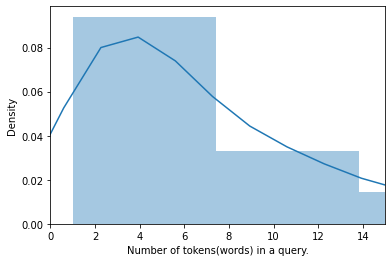

In [ ]:
# plot the number of words in a user query
sns.distplot(new_df['text_word_count'])
plt.xlim([0, 15]);
plt.xlabel('Number of tokens(words) in a query.');

### Look into the Fallback data

> ___Fallback (unable to determine which one)___ contains data, which was not labelled. Therefore, this is something I will further explore.

In [ ]:
# filter the rows where the intent starts with "faq.problemenActiveren"
fallb_df = new_df[new_df["intent"].str.startswith("Fallback (unable to determine which one)")]

# select only the 'query' column to see the user's input
fallb_df = fallb_df[["query"]]

# display the resulting DataFrame
fallb_df.tail(20)

,query
47994,ik ben bij dealer De Waal geweest en wil graag...
47995,proefrit in Polo GTI
47996,"We hebben een proefrit aangevraagd, maar nog g..."
47997,Geen bevestiging proefrit
47998,Kan ik een auto kopen als financieren
47999,Ik wil een auto financieren
48000,Hoe plan ik een proefrit?
48001,Ik wil graag een proefrit
48002,Als de vetkoper gaat dwingen
48003,Als de verkoper gaat dwingen?


In [ ]:
# check the shape of the fallback data frame
fallb_df.shape

(5003, 1)

In [ ]:
fallb_df["text_length"] = fallb_df["query"].astype(str).apply(len)
fallb_df["text_word_count"] = fallb_df["query"].apply(lambda x: len(str(x).split()))

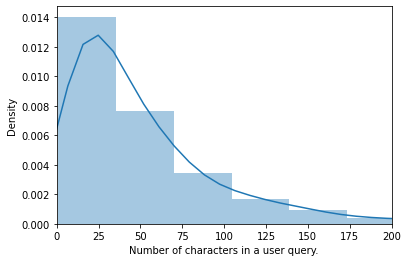

In [ ]:
# plot the length of the characters in a user query
sns.distplot(fallb_df["text_length"])
plt.xlim([0, 200]);
plt.xlabel("Number of characters in a user query.");

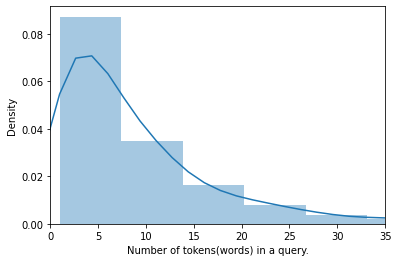

In [ ]:
# plot the number of words in a user query
sns.distplot(fallb_df["text_word_count"])
plt.xlim([0, 35]);
plt.xlabel("Number of tokens(words) in a query.");

In [ ]:
# look which are the 20 most common values in the query column
# fallb_df["query"].value_counts()[:20].plot(kind="barh")

> Looking at the data in the Fallback data frame, shows that the most occurred words contain noisy data. Therefore, it was classified as Fallback (it is unlaballed). 

## Data cleaning

In [ ]:
def clean_text(text):
    # convert to lowercase
    text = text.lower()

    # remove names
    # text = re.sub(r"\b([A-Z][a-z]+)\b", "[NAME]", text)

    # remove URLs
    text = re.sub(r"[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", "", text)

    # remove email addresses
    text = re.sub(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", "", text)

    # remove phone numbers
    # old regex \d{4,15}
    text = re.sub(r"\+?\d{1,}[- ]?\d{1,}[- ]?\d{1,}[- ]?\d{1,2}", "", text)
    # ^\+?\d{1,3}[-. ]?\(?\d{1,3}\)?[-. ]?\d{1,14}$

    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # remove emojis
    text = "".join(c for c in text if c not in emoji.EMOJI_DATA)

    # remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # remove numbers
    text = re.sub(r"\+?\d+(?:[ - ]?\d+)*", "", text)

    # remove special characters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

    # remove HTML tags
    text = re.sub(r"<.*?>", "", text)

    return text

In [ ]:
# apply the clean_text() function to the query column of the main query data and the query from the Fallback (unable to determine which one)
filt_df["clean_query"] = filt_df["query"].apply(clean_text)
filt_df["clean_intent"] = filt_df["intent"].apply(clean_text)
fallb_df["clean_fallback"] = fallb_df["query"].apply(clean_text)

In [ ]:
# define a regular expression pattern to match phone numbers
pattern = re.compile(r"[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)")

# check if 'clean_fallback' column contains phone numbers
has_phone_numbers = fallb_df["clean_fallback"].str.contains(pattern)

# get the row numbers where the condition is true
rows_with_phone_numbers = has_phone_numbers[has_phone_numbers == True].index

# print the result
if len(rows_with_phone_numbers) > 0:
    print("The following row(s) contain phone numbers: ")
    print(rows_with_phone_numbers)
else:
    print("No phone numbers found in 'clean_fallback' column.")

No phone numbers found in 'clean_fallback' column.


> The code for removing the name doesn't seem work, so it needs to be adjusted.

In [ ]:
# test the clean_text()

# sample text
text = "My name is Deyna 😋. You can reach me at john@upcmail.nl or +31 6 28 72 55 69 ###### # @."

# call the function
cleaned_text = clean_text(text)

# print the cleaned text
print(cleaned_text)

my name is deyna you can reach me at or


> Look into the rows, which consisted of a number and have became empty strings after cleaning.

In [ ]:
# check for values, which are empty strings
empty_str = fallb_df[fallb_df["clean_fallback"] == ""].index
print(empty_str)

Int64Index([46039, 45651, 45749, 43942, 45849, 45974, 45808, 45475, 45668,
            44178, 45539, 45514, 45597, 45512, 43686, 45054, 45783, 45569,
            45232, 45940, 47920, 45695, 45838, 45633, 45909, 43820, 45623,
            45683, 47804, 45751, 45770, 45971, 46031, 45905, 45382, 43684,
            47238, 47188, 47000, 46851, 46713, 46345],
           dtype='int64')


In [ ]:
# replace any empty strings in the "clean_fallback" column with np.nan objects
fallb_df["clean_fallback"].replace("", np.nan, inplace=True)

In [ ]:
# drop the nan values
fallb_df.dropna(subset=["clean_fallback"], inplace=True)

In [ ]:
# check for existing phone numbers in the query column and compare with the 'clean_fallback'

# define a regular expression pattern to match phone numbers
pattern = re.compile(r"\b\d{3}[-.]?\d{3}[-.]?\d{4}\b")

# create a boolean mask that indicates which rows in 'Phone Number' contain phone numbers
mask = fallb_df["query"].str.contains(pattern)

# filter the dataframe using the boolean mask to get only the rows that contain phone numbers
phone_numbers = fallb_df[mask]

# print the resulting dataframe
print(phone_numbers)

                                                   query  text_length  \
43230  Ik krijg zojuist een melding dat m’n abonnemen...          423   
44022  Ik heb eergisteren een abonnement afgesloten m...          253   
43074   Kunnen jullie mij bellen? 0648950634. Dankjewel            48   
44564  goedemorgen, kunt u aangeven wanneer abonnemen...           65   
42942  De voornaam van klantnummer 0058203167 is Carl...           79   
43030  Wilu mij bellen ik heb probleem om naar jullie...          141   
42910  L.S.,  Ik heb tijdens mijn telefonisch contact...         1601   
44588  hallo ik heb net een abonnement op Bicycling, ...         1175   
43692  Hierbij wil ik mijn proefabonnement op Tijdsch...          169   
45299  U mag proberen het abonnement te koppelen met ...           70   
43797  Tim, dat is dus nog steeds niet online gelukt,...          390   
43693  Geachte heer/mevrouw,  Langs deze weg zeg ik m...          310   
45434  Klantnummer: 0058120424 Abonnementsnummer: 3

In [ ]:
filt_df["clean_query"].describe()

count     7715
unique    7191
top           
freq        54
Name: clean_query, dtype: object

In [ ]:
# check for duplicates in the 'query' column
duplicates = filt_df.duplicated(subset=["query"])
print("Number of duplicate queries:", duplicates.sum())

Number of duplicate queries: 0


In [ ]:
data = df["query"]

In [ ]:
data.to_csv("all_data.csv")